In [1]:
# uncommeting the next line will enable autoreload, that is, if you change
# the code in a batram module, it will be reloaded automatically
# 
# %load_ext autoreload
# %autoreload 2

## Getting Started with the Transport Maps Approach for Multivariate Spatial Data

This notebook provides an introductory example of using the transport maps
approach for multivariate spatial data. It demonstrates how to fit a transport
map to a multivariate spatial field, assess the fit, and generate new samples
that replicate the characteristics of the training data. The example offers a
simple illustration of the method introduced in [1], applied to a 
simulated dataset based on the simulation scenario 1 described in [1].

The notebook covers the following steps.

- Data generation and visualization
- Fitting the seperable model
- Fitting a transport map
- Sampling new data
- Scoring data


### References

[1] Wiemann and Katzfuss ([2023](https://link.springer.com/article/10.1007/s13253-023-00580-z)).

### Load packages

First, we load the necessary packages to simulate the data, fit the transport map, and visualize the results.

In [2]:
# We load the required modules, functions, and classes.

# libraries for numerical computing and plotting
import numpy as np
import torch
from matplotlib import pyplot as plt

# imports for the multivariate transport map
from batram.data import MultVarData
from batram.mv import MultVarTM
from batram.seperable.fit import fit_seperable
from batram.seperable.gpcov import Data as DataSep
from batram.simulate import sim_LR_mv
from batram.stopper import EarlyStopper

### Configuration

We set up the variables used for data simulation and configuring the transport map. Additionally, we set a random seed to ensure reproducibility.

In [3]:
# seed used to generate the data
seed = 0

# number of locations per dimension of the spatial input sace (here we use a regular grid on the 2D unit interval)
num_locs_dim = 32

# Position of the processes in the three dimensional latent space
process_position = np.array(
    [
        [0, 0, 0],
        [0.2, 0, 0],
        [0, 0.3, 0],
        [0, 0, 0.4],
        [0.3, 0.3, 0],  # ~ dist 0.4 to p1
    ],
    dtype=np.float32,
)

# We use the first `num_processes` (can be between 2 and 5)
num_processes = 3


# number of replicates of the multivariate spatial field generated by the simulator
num_replicates = 60

# of those replacates, we use `num_test_size` for testing and `num_score_samples` for validation
# the rest is used for training
num_test_size = 10
num_score_samples = 10

# We can choose to use a subset of spatial locations for the initial training of the separable model to
# estimate starting values for the process positions
n_subsample_sep = 256

# Maximum size of the conditioning sets used in the multivariate transport map
size_cond_sets = 30

Now, we can get the data from the simluation using a function from the package.

In [4]:
gen = np.random.default_rng(seed)

# simulate data
data = sim_LR_mv(
    gen,
    process_position[:num_processes, :],
    num_locs_dim=num_locs_dim,
    num_reps=num_replicates,
    max_num_neibours=size_cond_sets,
    sd_noise=1.0,
    lrange=0.3,
    non_linear=True,
)

### Visualize Data

Below, we plot the first three samples from the simulated dataset. Each row
represents an independent sample, while the columns correspond to different
processes / variables.

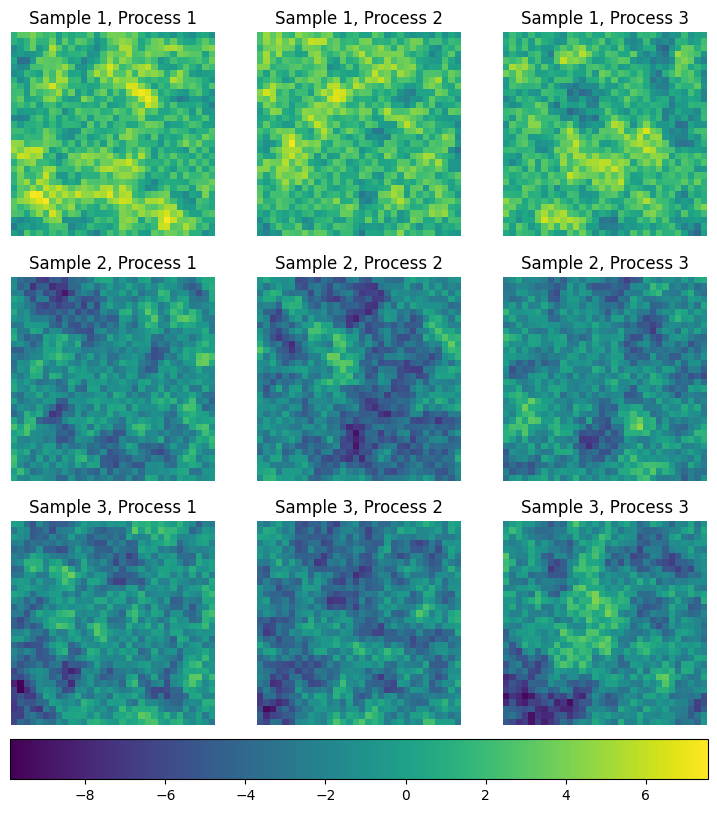

In [5]:
data_plot = data.response[:, data.ordering_inverse].reshape(-1, num_processes, num_locs_dim, num_locs_dim)
rows = np.min([3, data_plot.shape[0]])
vmin, vmax = data_plot[:rows].min(), data_plot[:rows].max()

fig, axs = plt.subplots(rows, num_processes, figsize=(num_processes * 3, rows * 3))
for i in range(rows):
    for j in range(num_processes):
        ax = axs[i, j]
        pcm = ax.imshow(data_plot[i, j, :, :], cmap="viridis", vmin=vmin, vmax=vmax)
        ax.set_title(f"Sample {i+1}, Process {j+1}")
        ax.axis("off")
        ax.set_aspect("equal")

fig.subplots_adjust(right=0.9)
cbar = fig.add_axes([0.125, 0.05, 0.775, 0.045])
fig.colorbar(pcm, cax=cbar, orientation="horizontal")
plt.show()


### Data preprocessing and fitting the sepeable model

Now, we proporcess the data. First, we split the simulated data into training,
test and validation (called score) sets. The training set is used to fit the
transport map, while the test set is used to evaluate the fit during training
and for early stopping. The score set is used to evaluate how well the fitted
transport map does on new data.

In terms of preprocessing, we could standardize the data at each location and
for each process. Here, we chose not do do so but provide code below to do the
standardization solely based on the training set.

Then, we fit the separable model to find initial values for the process
positions, we can use in the transport map.

In [6]:
# we split the data into training, test, and score data
data_van = data.to_vanilla()
data_train = data_van[:num_replicates]
data_test = data_van[-(num_score_samples + num_test_size) : -num_test_size]
data_score = data_van[-num_score_samples:]

# compute the mean and std of the training data at each spatial location for each process
# obs_means = np.mean(data_train.response, 0)
# obs_std = np.std(data_train.response, 0)

# # standardize the data
# data_train.response = (data_train.response - obs_means) / obs_std
# data_test.response = (data_test.response - obs_means) / obs_std
# data_score.response = (data_score.response - obs_means) / obs_std


In [7]:
# fit sperable model
data_sep = DataSep.from_vanilla(data_train)

model, likelihood, losses = fit_seperable(
    data_sep, subsample=n_subsample_sep, niters=500, lr=0.1, silent=False
)

loss: 1.982:   5%|▌         | 27/500 [00:30<08:50,  1.12s/it]

stopping early at iteration 27


### Fit the transport map

Now we fit the transport map. First, we convert the data to the appropriate
format using the `MultVarData` class. Then, we define the initial values for the
transport map parameters, initialize the transport map, and fit it to the
training data using the fit method.

The fit method optimizes the integrated likelihood of the training data using a
gradient-based approach. If test data is provided, the method also evaluates the
fit on the test data and can use it for early stopping. Similar to the original
transport map implementation, the user can either specify a detailed optimizer
configuration or rely on the default setup, which exposes only a few key
parameters through function arguments.

In this example, we specify the number of training epochs, the initial learning
rate, provide test data, and set parameters for early stopping—specifically, the
patience and the stopping threshold.

The `method` argument controls how the process locations are treated during
training, i.e.,  1 keep locations fixed, 2 allow updates to the locations, or 3
update locations with occasional reordering.

In [8]:
# convert to MultVarData
init_locs = model.process_locs()
mvtrain_dat = MultVarData.from_vanilla(data_train, init_locs, size_cond_sets)
mvdat_test = MultVarData.from_vanilla(
    data_test,
    init_locs,
    size_cond_sets,
)
# setup the multivariate transport map
theta_0_init = mvtrain_dat.response[:, 0].square().mean().log()
theta_init = torch.tensor([theta_0_init, 0.2, 0.0, 0.0, 0.0, -1.0])
tm = MultVarTM(
    mvtrain_dat,
    torch.as_tensor(model.process_locs()),
    theta_init=theta_init.clone(),
    linear=False,
    smooth=1.5,
    nugMult=4,
    new_method=True,
)

# fit the multivariate transport map
res = tm.fit(
    num_iter=500,
    init_lr = 0.025,
    batch_size=None,
    test_data=mvdat_test,
    stopper=EarlyStopper(50, 1e-3),
    method=2,
    silent=False,
)

Train Loss: 169008.969, Test Loss: 34408.070:  30%|███       | 151/500 [01:02<02:25,  2.40it/s]

Early stopping; best test loss: 34388.16406


### Inspect the fit

The model can be fit by minibatched optimization, so some caution should be taken to
verify the model has at least converged before using it for any kind of inference
or sampling. The `fit` method returns a `FitResult` object that contains
information about the optimization. This includes tracking the loss function and
model parameters at each iteration of the optimization. The `FitResult` object
has helper methods to plot the loss function.

Note: When batching is used, the reported test loss is not computed over the
entire dataset, but is the average of the batch losses observed during the
epoch.

The tracked data is also availabe through attributes of the `FitResult` object,
e.g., `res.losses` contains the training loss at each iteration, and `res.test_loss` contains
the test loss at each iteration.

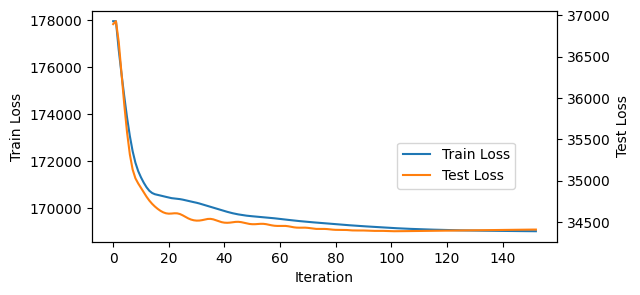

In [9]:
fig, axs = plt.subplots(1, 1, figsize=(6, 3), gridspec_kw={"wspace": 0.5})
res.plot_loss(axs, use_inset=False)
plt.show()


### Sampling

Now we show sampling new spatial fields from the fitted map. To draw `n` new
samples, the argument num_samples can be specified. For plotting, we 

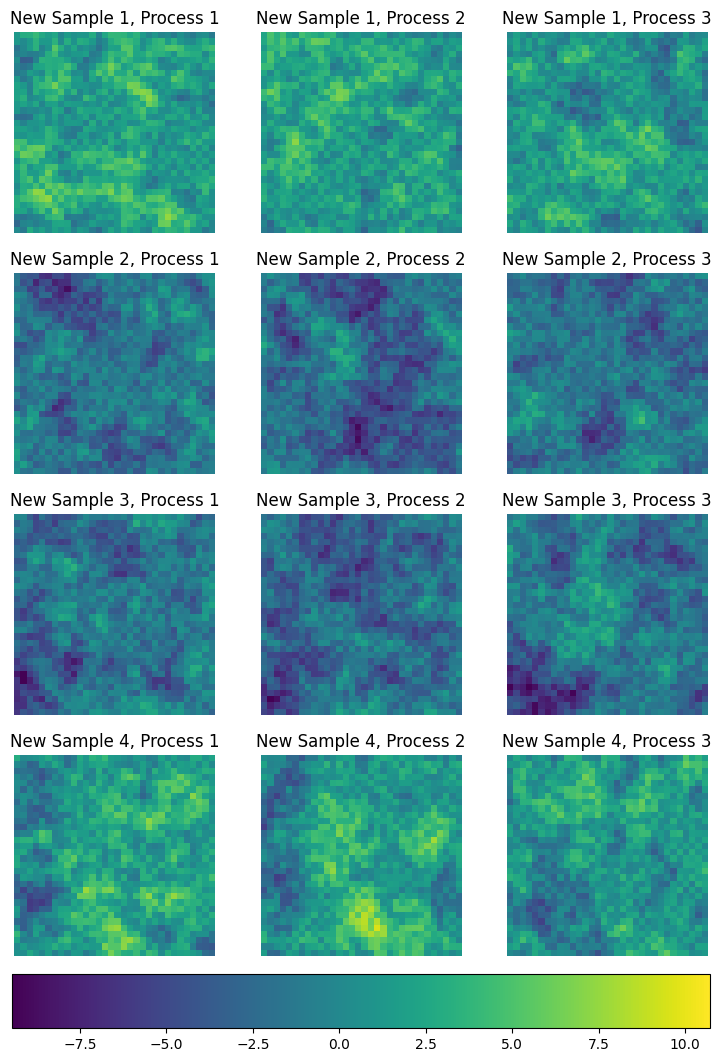

In [10]:
n_new_samples = 4

with torch.no_grad():
    new_sample = tm.cond_sample(num_samples=n_new_samples)
new_sample = new_sample[:, tm.data_mv.ordering_inverse].reshape(-1, num_locs_dim, num_locs_dim)
vmin, vmax = new_sample.min(), new_sample.max()

fig, axs = plt.subplots(n_new_samples, num_processes, figsize=(num_processes * 3, n_new_samples * 3))
for i in range(n_new_samples):
    for j in range(num_processes):
        ax = axs[i, j]
        pcm = ax.imshow(data_plot[i, j, :, :], cmap="viridis", vmin=vmin, vmax=vmax)
        ax.set_title(f"New Sample {i+1}, Process {j+1}")
        ax.axis("off")
        ax.set_aspect("equal")

fig.subplots_adjust(right=0.9)
cbar = fig.add_axes([0.125, 0.05, 0.775, 0.045])
fig.colorbar(pcm, cax=cbar, orientation="horizontal")
plt.show()


### Scoring

We can also score observations using the model. This is useful for evaluating if
a new sample or observation is consistent with the training data or comparing
multiple models on holdout data. The score is the negative log-likelihood of the
observation under the model. The lower the score, the more consistent the
observation is with the training data.

We convert the score data to the appropriate format using the `MultVarData`
class. We aware that the responses must use the same ordering as the transport
map.

In [11]:
mvdat_score = MultVarData.from_vanilla(
    data_score,
    init_locs,
    size_cond_sets,
)

with torch.no_grad():
    scores = tm.score(
        mvdat_score.response
    )
scores

tensor([-1145.9124, -1145.8025, -1144.8408, -1143.2886, -1146.9797, -1146.7703,
        -1142.9535, -1147.2136, -1145.9320, -1148.6782])